### Installing Qiskit

#### Normal installation

In [1]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### GPU installation

In [2]:
# %pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer-gpu python-dotenv

### Libraries Importing


In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from dotenv import load_dotenv
from sympy import *
import json
import time
import os

load_dotenv()
init_printing()
simulation_time = time.time()  # to calculate simulation time

In [27]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())

('CPU',)


#### Use GPU

In [28]:
# backend.set_options(device="GPU")

#### Use real quantum

In [29]:
services = []
current_token = 0
for i in range(1, 10):
    print(i)
    services.append(QiskitRuntimeService(
        channel="ibm_quantum", token=os.getenv(f"TOKEN{i}")))
    

# backend = services[current_token].backend("ibm_osaka") # for real quantum
backend = services[current_token].backend("ibm_kyoto") # for real quantum

1
2
3
4
5
6
7
8
9



### Problem Definition

In [30]:
conf = json.load(open("../conf_16.json", "r"))

In [31]:
N = conf["N"]  # Number of Teachers
M = conf["M"]  # Number of Classes
H = conf["H"]  # Number of hours in week

required_qubits = (M * N * H) + (M * H) + (N * H)
iterations = 0

random_seed = conf["random_seed"]
shots = conf["shots"] * 5
layers = 5

print("Requried Qubits: ", required_qubits)

Requried Qubits:  16


In [32]:
# T_i is binary string denoting the available hours for each i Teacher
# C_j is binary string denoting the available hours for each j Class

T = conf["T"]
C = conf["C"]

R = conf["R"]  # R_ij must be either 0 or 1

terms_count = 0
equations = []

### Formulation

#### Equations

In [33]:
for i in range(1, N + 1):
  for j in range(1, M + 1):
    temp = total = 0
    for h in range(1, H + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp - R[i-1][j-1])**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [34]:
for j in range(1, M + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for i in range(1, N + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"τ_{j}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

In [35]:
for i in range(1, N + 1):
  for h in range(1, H + 1):
    temp = total = 0
    for j in range(1, M + 1):
      temp += symbols(f"f_{i}{j}{h}")
    total += (temp + symbols(f"λ_{i}{h}") - 1)**2
    terms_count += len(total.expand().args)
    equations.append(total.expand())
equations

#### Decodeing Equations

In [36]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []

  for term in terms:

    term = str(term)

    if term.startswith("τ"):
      j = int(term[2])
      h = int(term[3])
      output.append((h-1) * M + (j - 1))


    elif term.startswith("λ"):
      i = int(term[2])
      h = int(term[3])
      output.append((H * M) + ((h-1) * N + (i - 1)))

    elif term.startswith("f"):
      i = int(term[2])
      j = int(term[3])
      h = int(term[4])
      output.append((H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1))

  return output


In [37]:
prepared_equations = []
for equation in equations:
    temp = []
    for term in args(equation):
        if len(term.args) != 0:
            temp.append(prepare_equation(term))
    prepared_equations.append(temp)

prepared_equations

### Implementation

#### Objective Function

In [38]:
def f(i, j, h):
  return int(T[i-1][h-1] == C[j-1][h-1] == '1')

def tau_value(bit_string, j, h):
  return int(bit_string[(h-1) * M + (j - 1)])

def lambda_value(bit_string, i, h):
  return int(bit_string[(H * M) + ((h-1) * N + (i - 1))])

def f_value(bit_string, i, j, h):
  return int(bit_string[(H * M) + (N * H) + ((i - 1) * H * M) + ((j - 1) * H) + (h - 1)])

In [39]:
def objective(bit_string):
  # since qiskit represent solution in least significant bit format
  bit_string = bit_string[::-1]
  cost = 0
  a = b = c = d = 0
  # equation a
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          for h in range(1, H + 1):
              if f(i, j, h) != f_value(bit_string, i, j, h):
                  cost += 1
                  a += 1

  # equation b
  for i in range(1, N + 1):
      for j in range(1, M + 1):
          temp = 0
          for h in range(1, H + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp - R[i-1][j-1])**2
          b += (temp - R[i-1][j-1])**2

  # equation c
  for j in range(1, M + 1):
      for h in range(1, H + 1):
          temp = 0
          for i in range(1, N + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + tau_value(bit_string, j, h) - 1)**2
          c += (temp + tau_value(bit_string, j, h) - 1)**2

  # equation d
  for i in range(1, N + 1):
      for h in range(1, H + 1):
          temp = 0
          for j in range(1, M + 1):
              temp += f_value(bit_string, i, j, h)
          cost += (temp + lambda_value(bit_string, i, h) - 1)**2
          d += (temp + lambda_value(bit_string, i, h) - 1)**2

  return [cost, a, b, c, d]

#### Circuit

#### Draw circuit 

In [40]:
# qc = QuantumCircuit(required_qubits)

# for i in range(required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#     for term in equation:
#         theta = int(term[0])
#         locations = term[1]
#         if len(locations) == 1:  # Rz Gate
#             qc.rz(theta * -1 , locations[0])

#         elif len(locations) == 2:  # Rzz gate
#             qc.rz(theta * -0.5 , locations[0])
#             qc.rz(theta * -0.5 , locations[1])
#             qc.rzz(theta * 0.5 , locations[0], locations[1])

# for qubit in range(required_qubits - 1):
#     qc.rx(1, qubit)

# qc.draw("mpl")

In [41]:
def layers_gen(p, initial_value=1.0):
    return [initial_value] * p * 2


def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits):
        qc.h(i)
    
    for layer_index in range(n_layers):
        for equation in prepared_equations:
            for term in equation:
                theta = int(term[0])
                locations = term[1]

                if len(locations) == 1:  # Rz Gate
                    qc.rz(theta * -1 * alpha[layer_index], locations[0])

                elif len(locations) == 2:  # Rzz gate
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[0])
                    qc.rz(theta * -0.5 * alpha[layer_index], locations[1])
                    qc.rzz(theta * 0.5 * alpha[layer_index], locations[0], locations[1])

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index], qubit)

    qc.measure_all()
    print(thetas)
    return qc

In [44]:
total = [0] * 4


def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj, a, b, c, d = objective(bit_string)
        total[0] += a
        total[1] += b
        total[2] += c
        total[3] += d
        avg += obj * count
        sum_count += count
    return avg/sum_count


def get_expectation():

    def execute_circ(theta):
        global iterations
        global backend
        global current_token
        qc = create_qaoa_circ(theta)
        tc = transpile(qc, backend, optimization_level=3,
                       seed_transpiler=random_seed)
        try:
            print(current_token)
            counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()
        except:
            print(current_token)
            current_token+=1
            backend = services[current_token].backend("ibm_kyoto")
            counts = backend.run(tc, seed_simulator=random_seed,
                             shots=shots).result().get_counts()

        
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [45]:
from scipy.optimize import minimize
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA')
minimization_time = time.time() - start_time

res

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


1


/tmp/ipykernel_33869/2072757878.py:35: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.24423828125
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.37353515625
[1. 2. 1. 1. 1. 1. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.29609375
[1. 1. 2. 1. 1. 1. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.21953125
[1. 1. 2. 2. 1. 1. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.5216796875
[1. 1. 2. 1. 2. 1. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.98720703125
[1. 1. 2. 1. 2. 2. 1. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.002734375
[1. 1. 2. 1. 2. 1. 2. 1. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.9369140625
[1. 1. 2. 1. 2. 1. 2. 2. 1. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.12109375
[1. 1. 2. 1. 2. 1. 2. 1. 2. 1.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.19853515625
[1. 1. 2. 1. 2. 1. 2. 1. 1. 2.]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.1994140625
[0.77803882 0.91098083 2.04241403 0.48130825 2.39882601 0.97334454
 2.08633686 0.68382267 0.55088067 0.54937187]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.77373046875
[0.59598074 0.83796508 2.07720308 1.19421329 2.72595304 0.95148107
 2.15715251 0.42448615 0.18250181 0.17975545]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.058203125
[0.96415711 0.44691188 2.04241403 0.48130825 2.39882601 0.97334454
 2.08633686 0.68382267 0.55088067 0.54937187]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.91689453125
[1.58885177 1.40039021 2.05556668 0.28568261 2.5225025  0.96507865
 2.11311004 0.58577566 0.41160816 0.40963148]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.7662109375
[1.58885177 1.40039021 2.55276301 0.28568261 2.46962706 0.96507865
 2.11311004 0.58577566 0.41160816 0.40963148]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.77705078125
[ 1.40504583  1.61287372  1.95000381 -0.05523672  1.72006767  0.95067357
  2.159768    0.41490786  0.16889616  0.16610409]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.5380859375
[1.58885177 1.40039021 2.05556668 0.28568261 2.5225025  0.46595109
 2.11311004 0.58577566 0.41160816 0.43915576]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.76318359375
[1.47431616 1.53279578 2.1000225  0.0732444  3.05904143 0.50816922
 2.14218417 0.47930223 0.26036621 1.21215747]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.78427734375
[1.32812819 1.54209348 2.06859812 0.10293957 2.64503921 0.45776138
 2.11311004 0.58577566 0.71840961 0.30070319]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.5951171875
[1.76136313 1.41011969 2.10407823 0.21164295 3.15348924 0.44375839
 2.15599858 0.42871201 1.40710559 0.15141473]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8880859375
[1.39652757 1.60489318 1.85443902 0.07669509 2.80715138 0.68287536
 2.11311004 0.90763575 0.64113566 0.20958247]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.2126953125
[ 1.07467089  1.44277841  2.71981351  0.04162013  2.56119362 -0.20923042
  2.13473802  0.79188924  0.75529614  0.3435402 ]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.7412109375
[1.12263168 1.67253238 2.09609919 0.4144513  2.78177214 0.43551298
 2.11751164 0.36688022 0.60795347 0.18393426]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.03984375
[ 1.34153457  1.46499313  2.08497638 -0.00710929  2.72549368  0.44440828
  1.98963271  0.51948832  0.62425066  0.20668721]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.18720703125
[1.32387528 1.6537856  2.05589077 0.22899252 2.52152584 0.46561536
 1.72012676 0.64767879 0.8739748  0.45455488]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.4580078125
[1.20633829 1.45560899 2.01681717 0.28097707 2.53173742 0.5076766
 1.71301219 0.6737333  0.91098436 0.48933071]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.5041015625
[1.48619193 2.00833507 2.0832069  0.12678958 2.31362935 0.41821835
 1.86286302 0.55249737 0.95293821 0.52952537]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.926953125
[1.34961867 1.62087031 2.04600143 0.28104046 2.38654361 0.44975639
 1.7128812  0.67914847 0.90891184 0.26165094]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.9052734375
[1.32299856 1.70993392 2.34035811 0.27686573 2.62491037 0.19426728
 1.73807385 0.92524099 0.84015577 0.48298623]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.2603515625
[1.4827918  1.62864688 2.06983838 0.2918872  2.63882455 0.4626342
 1.725877   0.59900478 0.99902836 0.42896558]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.938671875
[1.07319993 1.45503582 1.97056539 0.22548315 2.39892444 0.55293255
 1.8374293  0.62667914 0.98945762 0.75484658]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.83515625
[1.31720353 1.73674523 1.9358075  0.2351416  2.5833756  0.59128202
 1.73018371 0.78693168 0.82920824 0.45570841]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.0265625
[1.32285022 1.6544438  1.96816903 0.23072971 2.53156834 0.37729088
 1.72015049 0.64649881 0.87328207 0.45918695]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.72529296875
[1.21496144 1.73359028 2.09085186 0.38173568 2.55832645 0.47612292
 1.727713   0.52660077 0.81754722 0.43584568]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.85458984375
[1.38746754 1.62412828 2.05151452 0.28195692 2.48554295 0.46858065
 1.72880217 0.65233608 0.80465097 0.49543007]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.94091796875
[1.27935512 1.63166137 2.11429042 0.04376013 2.54644672 0.49304896
 1.60489246 0.56650138 0.85016149 0.43225073]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8693359375
[1.34688975 1.73901331 2.06780503 0.19412857 2.47107375 0.46141457
 1.76448449 0.62551606 0.90377707 0.4783056 ]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.9306640625
[1.32623073 1.64325992 2.05780714 0.21218741 2.53841893 0.46437139
 1.76698051 0.63967232 0.85158684 0.43319357]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.66630859375
[1.25902603 1.58821276 2.05823421 0.23923879 2.50767412 0.48560788
 1.73813039 0.66252432 0.93728599 0.49773936]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.82138671875
[1.3112921  1.67257578 2.12864479 0.23620063 2.55027828 0.40798036
 1.70365238 0.72048607 0.86726326 0.45292895]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.92255859375
[1.32031443 1.6456106  2.05555485 0.19735159 2.52673263 0.4779345
 1.67605847 0.62397    0.86431168 0.44754707]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.0025390625
[1.3133889  1.65567514 2.06613666 0.24291632 2.52084903 0.45601644
 1.72013868 0.62616089 0.87131549 0.4533349 ]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.0859375
[1.31765907 1.67758453 2.02822104 0.24303687 2.53822087 0.49933659
 1.72161751 0.67732728 0.87228275 0.44835824]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.94091796875
[1.31269902 1.65291412 2.05379813 0.22839984 2.49918535 0.46441795
 1.71897407 0.65470328 0.86652335 0.43908114]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.61923828125
[1.36177144 1.63772243 2.05727622 0.23482284 2.51899215 0.46400842
 1.71865175 0.65338852 0.90964904 0.42523316]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.03544921875
[1.32344055 1.65243751 2.03454411 0.22331823 2.52371111 0.44472264
 1.71969264 0.65078818 0.87469674 0.46047259]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.73349609375
[1.33399398 1.65635406 2.05520152 0.23323362 2.51957186 0.46431837
 1.71760795 0.64727321 0.86374849 0.45488204]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.65498046875
[1.32255719 1.63753076 2.06117666 0.22452132 2.51385168 0.47532542
 1.72657233 0.65624437 0.87528526 0.47437565]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8609375
[1.32090417 1.64772985 2.06075727 0.23231288 2.52850737 0.46131052
 1.71574528 0.6553371  0.87046876 0.45200131]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.897265625
[1.32622172 1.67509805 2.06851157 0.21365945 2.51886638 0.46051956
 1.7234725  0.6537802  0.87976238 0.45729192]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.98955078125
[1.33186526 1.64993202 2.05386752 0.23024183 2.51942796 0.46731972
 1.72108676 0.64597317 0.88418049 0.44788379]
2


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


2


/tmp/ipykernel_33869/2072757878.py:35: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.76826171875
[1.32462245 1.65152997 2.05669513 0.22548041 2.52313865 0.46489993
 1.72490034 0.6459769  0.87123216 0.45208737]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.91484375
[1.31915134 1.66060296 2.04827362 0.23372552 2.52387249 0.47458572
 1.71884253 0.64958377 0.87473351 0.45631513]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.61904296875
[1.32315835 1.65190262 2.05511063 0.22126842 2.52120435 0.46876674
 1.70824287 0.6424054  0.87328707 0.45507236]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.69736328125
[1.32377749 1.65116113 2.0567914  0.22987994 2.51779513 0.46666592
 1.72078991 0.64893589 0.87489634 0.46044112]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.99775390625
[1.32527664 1.65434628 2.05659572 0.22883094 2.52424907 0.46562017
 1.72028512 0.64696422 0.87491695 0.45645704]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8625
[1.32288337 1.65890006 2.05766056 0.22727763 2.51839247 0.46370053
 1.71925882 0.65016161 0.87486965 0.45198242]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.940625
[1.32432385 1.65355118 2.05310822 0.22772376 2.52179311 0.46381916
 1.72007945 0.64903012 0.87417816 0.45524971]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.97138671875
[1.32095968 1.65354963 2.05540619 0.23306361 2.52060091 0.46287425
 1.71955305 0.64259384 0.873885   0.45350276]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.92724609375
[1.3236342  1.65299324 2.05602146 0.2272199  2.52123436 0.46709575
 1.71740382 0.6465341  0.87346118 0.45416951]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.97578125
[1.32285441 1.65369225 2.05640838 0.22906142 2.52220671 0.46518516
 1.71977065 0.64835423 0.8729337  0.45497389]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.610546875
[1.3246452  1.6523201  2.05642964 0.23095218 2.52193868 0.46628667
 1.72015865 0.64936658 0.87496609 0.45257138]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.77421875
[1.32520627 1.65391234 2.05606722 0.22943946 2.52114973 0.4651529
 1.71970427 0.64762282 0.87285442 0.45461823]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.84658203125
[1.32306063 1.6554282  2.05433359 0.22980959 2.52163298 0.46815835
 1.72140436 0.64772595 0.87314416 0.4545987 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.861328125
[1.32300649 1.65367621 2.05576992 0.22975431 2.52133655 0.46482518
 1.72025048 0.64646725 0.87449085 0.4543467 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.76533203125
[1.32387837 1.6544468  2.05595982 0.22883078 2.52176738 0.46539468
 1.71994724 0.64772494 0.87404205 0.4539721 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.07880859375
[1.32371596 1.65330005 2.05656953 0.22870438 2.52045763 0.46593355
 1.72074689 0.64811844 0.87441952 0.4555508 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.7576171875
[1.32394494 1.65320235 2.05583385 0.22876269 2.52172986 0.4656691
 1.72065164 0.6473971  0.87360858 0.45441669]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.906640625
[1.32379022 1.65502411 2.05656996 0.22824365 2.52146542 0.46526639
 1.72029535 0.6480306  0.87435685 0.453645  ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.91103515625
[1.32368917 1.65425264 2.05546989 0.2293543  2.52150218 0.46620677
 1.72016628 0.64776487 0.87387382 0.45470779]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.870703125
[1.32383223 1.65375012 2.05614845 0.22896287 2.52150812 0.4658854
 1.71992118 0.64746593 0.87392706 0.45448452]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.63837890625
[1.32389259 1.65351852 2.05545487 0.22865119 2.521501   0.46536465
 1.71952918 0.64789443 0.87429319 0.45463898]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.9396484375
[1.32381225 1.65361272 2.05589534 0.22917738 2.52136842 0.46566394
 1.72010945 0.64789586 0.87396581 0.45424548]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8201171875
[1.32419734 1.65375892 2.05619514 0.2293494  2.52213194 0.46558064
 1.72022116 0.64779625 0.87441366 0.45476785]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8373046875
[1.32369844 1.65384914 2.05588862 0.22915883 2.52141482 0.46534671
 1.72015856 0.64739147 0.87403649 0.45461465]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.933984375
[1.32374789 1.65374967 2.05594093 0.22902104 2.52160111 0.46557416
 1.72007492 0.64775951 0.87385057 0.45463707]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.94697265625
[1.32400478 1.65407249 2.05595626 0.22871227 2.52149455 0.46560249
 1.72025787 0.64772583 0.87405695 0.45438393]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.0265625
[1.32398286 1.65383853 2.05584153 0.22904994 2.52159646 0.46555413
 1.72004093 0.64763498 0.87385605 0.45446894]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.86845703125
[1.32414384 1.65371046 2.05595331 0.22903325 2.52123227 0.46565397
 1.72015659 0.64771903 0.87392654 0.45480502]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.7271484375
[1.3238389  1.65382858 2.05574131 0.22903813 2.52153631 0.4657762
 1.72016734 0.64765657 0.87401873 0.4545992 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.57919921875
[1.32389321 1.65383138 2.05592899 0.22905164 2.52155338 0.46561522
 1.72009351 0.64771501 0.87403825 0.45457292]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.9712890625
[1.32392032 1.65361595 2.05588784 0.22893976 2.52160786 0.46561675
 1.72024011 0.64760664 0.87400559 0.45453842]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.61435546875
[1.32385658 1.65371967 2.05578956 0.22887147 2.52147544 0.46557926
 1.71998015 0.64768034 0.87404259 0.45456354]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.79482421875
[1.32383439 1.65379699 2.05588799 0.22901119 2.52147965 0.46557899
 1.72015363 0.64761845 0.87397499 0.45455018]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.0841796875
[1.32386286 1.6537855  2.05591367 0.2289864  2.52153254 0.465641
 1.72010778 0.64765636 0.87397451 0.45454009]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.96162109375
[1.32393229 1.65376935 2.05589235 0.228988   2.52147765 0.46563271
 1.72013848 0.64770411 0.87394211 0.45459952]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.6451171875
[1.32388114 1.65380958 2.05589403 0.2289674  2.5215419  0.46560912
 1.72013085 0.64766269 0.87397424 0.45458088]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.7525390625
[1.32386895 1.65380077 2.05586833 0.22896383 2.52152688 0.46560744
 1.72016696 0.64774389 0.87397227 0.45450508]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.191015625
[1.3238683  1.6537734  2.05592273 0.22898448 2.52152701 0.46558609
 1.72011886 0.64769033 0.87396211 0.4545563 ]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.8953125
[1.32383189 1.65376187 2.05584722 0.22902728 2.52155906 0.4656312
 1.72012186 0.64769539 0.87394412 0.45459794]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.00595703125
[1.32386436 1.65379575 2.0558744  0.22897776 2.521505   0.46561032
 1.72009171 0.64768742 0.87397891 0.45455838]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.94375
[1.3239143  1.6537236  2.05586173 0.22898504 2.52154435 0.46559859
 1.72013041 0.64765686 0.87402573 0.45455029]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.77666015625
[1.32389761 1.65379762 2.05587548 0.22900765 2.52153569 0.46559424
 1.72011572 0.64767255 0.87395218 0.45454152]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


15.903125
[1.3238788  1.65377242 2.0559249  0.22898844 2.52153323 0.46569449
 1.72011955 0.64764718 0.87396401 0.45452098]
3


/tmp/ipykernel_33869/2072757878.py:29: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


16.29462890625


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 16.29462890625
       x: [ 1.324e+00  1.654e+00  2.056e+00  2.290e-01  2.522e+00
            4.657e-01  1.720e+00  6.476e-01  8.740e-01  4.545e-01]
    nfev: 95
   maxcv: 0.0

In [46]:
print("a:", total[0])
print("b:", total[1])
print("c:", total[2])
print("d:", total[3])

a: 6918420
b: 7111212
c: 7208512
d: 7171236


### Results

[1.3238788  1.65377242 2.0559249  0.22898844 2.52153323 0.46569449
 1.72011955 0.64764718 0.87396401 0.45452098]


/tmp/ipykernel_33869/4133922901.py:6: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  counts = backend.run(tc, seed_simulator=random_seed,


9238
-----------------
BINGO
1000000101100110
1
-----------------
Solution 1000001010111110 cost: 6 count 4
Solution 0010101111010110 cost: 19 count 4
Solution 1000010111010111 cost: 10 count 4
Solution 1001001110110001 cost: 12 count 4
Solution 1011001111110010 cost: 17 count 3
Solution 0000110010111011 cost: 14 count 3
Solution 1000000110100111 cost: 3 count 3
Solution 1011001111101001 cost: 21 count 3
Solution 1000010001100111 cost: 5 count 3
Solution 1110110111101001 cost: 23 count 3


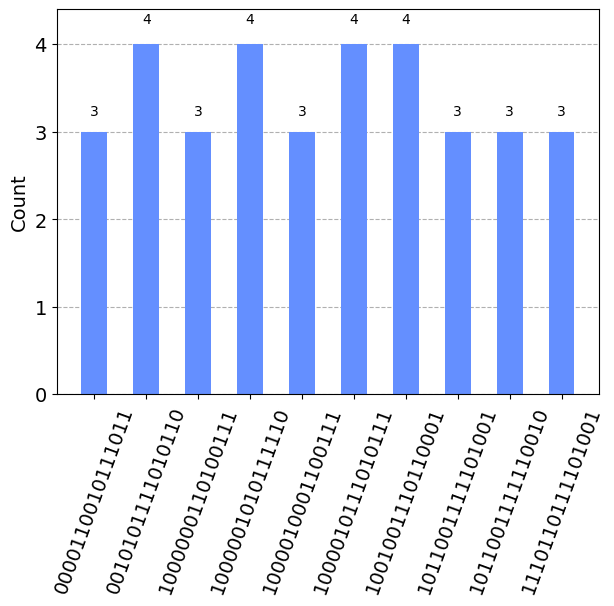

In [47]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
tc = transpile(qc_res, backend, optimization_level=3,
                seed_transpiler=random_seed)
counts = backend.run(tc, seed_simulator=random_seed,
                     shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
counts_cost = dict(
    sorted(counts.items(), key=lambda item: item[1], reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
    if objective(key)[0] == 0:
        print("-----------------")
        print("BINGO")
        print(key)
        print(counts[key])
        print("-----------------")

for key in binary[:10]:
    print("Solution", key, "cost:", objective(key)[0], "count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [48]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["M"] = M
counts["N"] = N
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 1000000101100110 cost: 0 count 1


In [49]:
file = open(f"../json/{H}_{M}_{N}_{shots}_{layers}_quantum.json", "w")
file.write(json.dumps(counts))
file.flush()

In [50]:
counts["execution_time"]

In [51]:
minimization_time